# Imports

In [1]:
import mujoco
import distutils.util
import os
import subprocess
import mediapy as media
import matplotlib.pyplot as plt
import time
import itertools
import numpy as np

# Viewer 

If you want to see in real time the system:

1.  Open the terminal 
2.  Change the envirorment where mujoco library is installed ( using *conda*)
3.  Go to the git folder path (`cd $PATH/MirrorSim` or `dir $PATH/MirrorSim`)
4.  Run the command `python -m mujoco.viewer`


# TODO

In [2]:

#superfice davanti e calcoli posizione e la estrai dai sensori
#guardare https://mujoco.readthedocs.io/en/latest/XMLreference.html#body-flexcomp   
#e https://mujoco.readthedocs.io/en/latest/modeling.html#deformable-objects

#FIXME:
#Volume dello specchio me pare strana perche il silicio ha 2330 kh/m^3 ma se vai a calcolare da valore strano 
#Controllare la realisticita del damping 




# CODE

Where to edit the model (xml) and show an image of the system

### Variables

In [3]:

#NB: c'è un fattore di conversione col fatto che sto usando questa libreria:
#       scala oggetti = 0.002 -> Se il filo è lungo 2 [m] = 200 [mm] ==> 200mm * 0.002 = 0.4 [mm] (IL PACCHETTO USA I [mm])
#       Per il contrario:     misura del programma / scala =>  0.4 [mm] / 0.002 = 200 [mm] = 2 [m]

#Distances
pos_hookP = 0.375                                   # z position of hook point of marionetta
                                                    # Attacco tra cavo e marionetta che puo essere modificato( 0.435 max  ,0.375 min [mm])=> Valori reali (217.5 max, 187.5 min[mm])
                                                    
#Converter measure real-> simulation
#pos_hookP= "value" * 0.002                         #insert value here!


dist_hookP_anchorP = 0.6 - (pos_hookP - 0.08)       #lunghezza filo tra attacco e soffitto (posizione soffitto - (pos_hookP + posizione marionetta)) [mm]  EX: 0.6 - (0.375 - 0.08 ) = 0.305 [mm] (in valori reali: 300 -(187.5 - 40 ) [mm] )
   

#Density
rho_M=2700                                          #densita marionetta   Al = 2700 kg/m^3    Si = 2330 kg/m^3 
rho_S=2330                                          #densita specchio  supponendo che sia vetro silicato  2,33g/cm^3  Mirror_weight = 100 kg  Volume = 887488.402932648 mm^3 (From Freecad macro) 

#Position of magnets 
                        # Mirror
                        # *Up-Dx =  0.13 -0.04 0.045
                        # *Up-Sx = -0.13 -0.04 0.045
                        # *Down-Sx = 0.13 -0.04 -0.208
                        # *Down-Dx = 0.13 -0.04 -0.208

                        # Marionetta
                        # *Behind-Dx = 0.17 0.15 0.363
                        # *Behind-Sx = -0.17 0.15 0.363
                        # *Front-Sx = -0.17 -0.15 0.363
                        # *Front-Dx = 0.17 -0.15 0.363


Q_Si=10**7                                           #For mirror cable
Q_Fe=10**4                                           #For marionetta cable
Damping_mirror=1/(2*Q_Si)
Damping_marionetta=1/(2*Q_Fe)
print("Damping_mirror", Damping_mirror)
print("Damping_marionetta", Damping_marionetta)


Damping_mirror 5e-08
Damping_marionetta 5e-05


### XML

libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init
No plugins found, falling back on no decorations


""

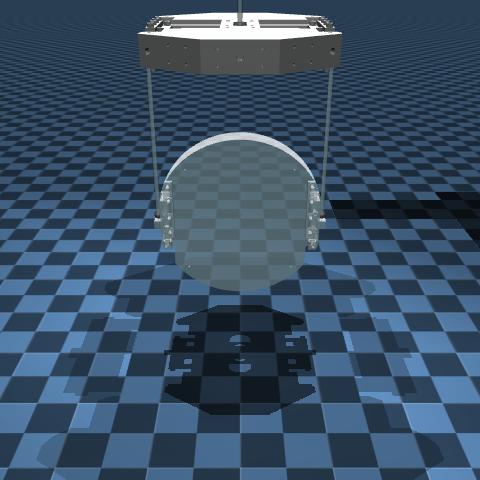

In [4]:


#come inserire variabili nello xml:
#       1) creare variabile
#       2) inserirla nel xml usando "{variabile}"


MJCF = f"""
<mujoco>
  
  <option timestep=".001">
    <flag energy="enable"/>
  </option>

<!--Observations

#Distances
pos_hookP = 0.375                                   # z position of hook point of marionetta
dist_hookP_anchorP = 0.6 - (pos_hookP - 0.08)       #lunghezza filo tra attacco e soffitto (posizione soffitto - (pos_hookP + posizione marionetta)) [mm]  EX: 0.6 - (0.375 - 0.08 ) = 0.305 [mm]
#Density
rho_M=2700                                          #densita marionetta   Al = 2700 kg/m^3    Si = 2 330 kg/m^3
rho_S=2500                                          #densita specchio

-->

<!-- Parte visuale -->

  <compiler  texturedir=""/>
  <statistic meansize=".05"/>

  <visual>
    <rgba haze="0.15 0.25 0.35 1"/>
    <quality shadowsize="4096"/>
    <map stiffness="700" shadowscale="0.5" fogstart="1" fogend="15" zfar="40" haze="1"/>
  </visual>

  <asset>
    <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
    <material name="matplane"  texture="texplane" texrepeat="10 10" texuniform="true"/>       <!--Se vuoi il riflesso del pavimento +reflectance="0.3"+ -->
    
  </asset>

  <worldbody>
    <light diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 2.0" dir="0 0 -1" castshadow="false"/>
    <light directional="true" diffuse=".8 .8 .8" specular="0.2 0.2 0.2" pos="0 0 4" dir="0 0 -1"/>
    <geom name="ground" type="plane" size="0 0 1" pos="0 0 -0.5" quat="1 0 0 0" material="matplane" condim="1"/>
  </worldbody>

<!-- Finita parte visuale  -->  


<!-- Finita parte prove  -->  


  <asset>
    <material name="reflectance" reflectance="1"/>             <!-- caratteristiche -->
    <material name="wire_mat" rgba="0.8 0.8 0.8 1"/>

    <!-- CAMBIARE IL PATH DEI FILE STL -->
    <!-- <mesh name="wire" file="STL/assieme_dondola1-Fibra_1.15-1.STL" scale= "0.002 0.002 0.002"/>      Usata per test    -->

    <mesh name="specchio" file="STL/Specchio2.stl" scale="0.002 0.002 0.002" />                        <!-- Specchio collegamento al file STL -->
    <mesh name="Marionetta" file="STL/Marionetta.stl" scale="0.002 0.002 0.002" />                     <!-- Marionetta collegamento al file STL -->
  
  <!-- ========================================================================================================  -->

  </asset>

  <option gravity="0 0 -9.81" viscosity="0.00002"/>             <!-- Parametri fisici -->

  <worldbody>
    <light name="light" pos="0 0 1"/>                           <!-- Luce -->
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> <!-- Telecamera -->
    <site name="anchorP" pos="0 0 0.6"  size="0.01"/>           <!-- Ancora soffitto-->


  <!-- ========================================================================================================  -->

                                                                                                                      
  <!-- Specchio che si muove e riflette -->                                                                                                                  
    <body name="mirror" pos="0 0 -0.08">
      <joint name="freeS" type="free"/>
      <geom type="mesh" mesh="specchio"   pos="0 0 -0.37" density="{rho_S}" rgba="0.8 0.96 1 0.5" size=".2" euler="90 270 0" />            <!--Centro di massa si trova verso il 2 buco (-0.37), ma non stai considerando i pasetti e tutto-->
      <site name="hookSSx" pos="-.2 0 0" size=".01"/>                                                                 <!-- L'attacco si trova a -0.3455 -->
      <site name="hookSDx" pos=".2 0 0" size=".01"/>
      <inertial pos="0 0 0" mass="0.1" diaginertia="0.1 0.1 0.1" />
      <site name="sensor_mirror" pos="0 -0.030 0" rgba="1 0 0 0.3" size="0.001 0.001 0.001" type="box"/>  
      <site name="IMU"/>
    </body>

    
  <!-- ========================================================================================================  -->

  
  <!-- Marionetta che si muove -->

   <body name="marionetta" pos="0 0 -0.08 ">
      <joint name="freeM" type="free"/>
      <geom type="mesh" mesh="Marionetta"  size= "0.2" pos="0 0 -0.325" density="{rho_M}"  euler="90 90 0" rgba="0.67 0.68 0.68 1"/>
      <site name="hookMSx" pos="-.2 0 .4" size=".01"/>                                                                 <!-- L'attacco sx si trova a -0.325 -->
      <site name="hookMDx" pos=".2 0 .4" size=".01"/>                                                                  <!--attacco dx-->
      <site name="hook_P" pos="0 0 {pos_hookP}" size=".01"/>                                                           <!-- Attacco tra cavo e marionetta che puo essere modificato( 0.375 z [mm] valore piu basso)-->
      <inertial pos="0 0 0" mass="0.1" diaginertia="0.1 0.1 0.1" />
      <site name="sensor_marionetta" pos="0 -0.030 0" rgba="1 0 0 0.3" size="0.001 0.001 0.001" type="box"/>  
      <site name="IMUM"/>
    
    </body>

    <!-- 

    <body>
      <geom name="sensore" pos="0 -0.030 -0.08" rgba="1 0 0 0.3" size="0.007 0.007 0.007"/>                             Per vedere il sensore davanti allo specchio 
    </body>


    <body name="wirse" pos="0 0 -0.1 ">
      <joint name="freM" type="free"/>
      <geom type="mesh" mesh="wire" size="0.2" pos="0 0 -.37"  euler="90 90 0" rgba="0.8 0.6 0.4 1"/>             Usata per tests
    </body> 
                                                                                                                  
    <body>                                                                                                        
        <geom name="Punto" pos="0.13 -0.04 -0.208" contype="0" size=".01" rgba="0 1 0 1"/>                        To find position of objects 
    </body>
  

   Position of points: 
                          Mirror
                          *Up-Dx =  0.13 -0.04 0.045
                          *Up-Sx = -0.13 -0.04 0.045
                          *Down-Sx = 0.13 -0.04 -0.208
                          *Down-Dx = 0.13 -0.04 -0.208

                          Marionetta
                          *Behind-Dx = 0.17 0.15 0.363
                          *Behind-Sx = -0.17 0.15 0.363
                          *Front-Sx = -0.17 -0.15 0.363
                          *Front-Dx = 0.17 -0.15 0.363

        -->

  </worldbody>


<!-- PER VEDERE GLI ASSI CARTESIANI https://mujoco.readthedocs.io/en/latest/programming/samples.html#sasimulate -->


  <worldbody>
    <body name="x" pos="0.8 1 1">
        <geom name="x" type="box" size="0.4 0.1 0.1" pos="0 0 0" rgba="1 0 0 1"/>
    </body>
    <body name="y" pos="1 0.8 1">
      <geom name="y" type="box" size="0.1 0.4 0.1" pos="0 0 0" rgba="0 1 0 1"/>
    </body>
    <body name="z" pos="1 1 0.8">
    <geom name="z" type="box" size="0.1 0.1 0.4" pos="0 0 0" rgba="0 0 1 1"/>
    </body> 
  </worldbody>

  
  <!-- ========================================================================================================  -->

  <tendon><!--collegamento lato dx specchio-marionetta-->
    <spatial name="wire1" limited="true" range="0 .4" width="0.005" damping="{Damping_mirror}" rgba="0.8 0.96 1 0.5">                   <!-- lunghezza reale del filo 200mm (formula scritta sotto)-->
      <site site="hookMSx"/>
      <site site="hookSSx"/>
    </spatial>
  </tendon>
  
  <tendon> <!--collegamento lato sx specchio-marionetta-->
    <spatial name="wire2" limited="true" range="0 .4" width="0.005" damping="{Damping_mirror}" rgba="0.8 0.96 1 0.5">                   <!-- lunghezza reale del filo 200mm (formula scritta sotto)-->
      <site site="hookMDx"/>
      <site site="hookSDx"/>
    </spatial>
  </tendon>

  <tendon><!-- collegamento soffitto-marionetta-->
    <spatial name="CavoPrincipale" limited="true"  range= "0 {dist_hookP_anchorP}" width="0.005" damping="{Damping_marionetta}" rgba="0.8 0.96 1 0.5" >         <!-- rapporto lunghezza:  lunghezza simulatore(mm) = lunghezza vera(mm) * 0.002 (su ogni asse)-->
      <site site="anchorP"/>                                                                                            <!-- Lunghezza del filo puo essere definita come (punto_anchor - punto_hook)-->
      <site site="hook_P"/>                                                                                             <!-- NB! Punto_hook = posizione_oggetto(che ha l'hook) + posizione_hook(rispetto all'oggetto)  -->
    </spatial>
  </tendon>

  <sensor>
    <force name = "force_mirror" site="sensor_mirror" />
    <force name = "force_marionetta" site="sensor_marionetta" />
  </sensor>

</mujoco>

"""


model = mujoco.MjModel.from_xml_string(MJCF)
data = mujoco.MjData(model)
height = 480
width = 480

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")

  media.show_image(renderer.render())





### Simulation

Simulation of the system with a 6 sec of video at 60 fps.
Here you can extract data like accelerometer and time.


In [5]:
#Video settings
n_frames = 400     # number of frames = time * fps   es  400frames = 6sec * 60fps
fps = 60.0          

#Image settings 
height = 240                    
width = 320


#Varibles
frames = []                     #image array 
times = []                      #time array
accelerationdata = []           #data sensor
ForceMirrorData=[]              #data force
Sensor_Mirror_Position=[]       #position of marionetta sensor ( position of center-front mirror )


#Force applied
Force = [0,0,0]             #Force = [x,y,z] (+ to right, + to back, + to up) in camera frame   To test use .0001 
Torque = [0,0,0]                        #Torque = the axis are the axes of torque (+ down , + clockwise, +counterclockwise)
point_on_body = [0, 0, 0]               #Location of the force in the body frame (x,y,z) (the front and back surface of the mirror is at ([-0.1908,0.1908], -0.030 , [-0.202,0.198] ))


# constant actuator signal
mujoco.mj_resetData(model, data)
data.ctrl = 20

#to get id of objects
mirror_id=data.body("mirror").id

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:
      mujoco.mj_step(model, data)
      mujoco.mj_applyFT(model, data, Force, Torque, point_on_body, mirror_id, data.qfrc_applied)   #Application of forces
      times.append(data.time)                                                                      #Appending time
      ForceMirrorData.append(data.sensor('force_mirror').data.copy())                              #acceleration array appending
      Sensor_Mirror_Position.append(data.site('sensor_marionetta').xpos.copy())                    #position of sensor
      
      # if(data.time>0.1):                                                                         Se ti serve provare una forza per una durata di tempo
      #   Force=[0,0,0]
      #angle[i] = data.joint('root').qpos                                                          se si vuole l'angolo basta inserire il nome del giunto e usi qpos

    renderer.update_scene(data, "fixed")                              
    frame = renderer.render()                                         #appending image of frames (fixed ha il sistema fisico)
    frames.append(frame)

media.show_video(frames, fps=fps)      #visualization video


#Per la forza applicata sul corpo:
# https://github.com/google-deepmind/mujoco/discussions/641




### Graphs and Data Elaboration

Graphical rappresentation of accelerometer

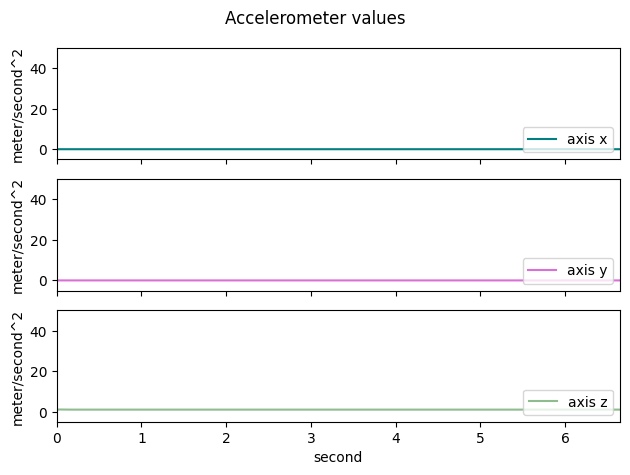

In [6]:


#Exctration of accelerometer data
acceleration_x = []
acceleration_y = []
acceleration_z = []


for i in range(len(ForceMirrorData)):
  acceleration_x.append(ForceMirrorData[i][0])
  acceleration_y.append(ForceMirrorData[i][1])
  acceleration_z.append(ForceMirrorData[i][2])


fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Accelerometer values')
axs[0].plot(np.asarray(times), np.asarray(acceleration_x), label=["axis x"], color="teal")
axs[1].plot(np.asarray(times), np.asarray(acceleration_y), label=["axis y"], color="orchid")
axs[2].plot(np.asarray(times), np.asarray(acceleration_z), label=["axis z"], color="darkseagreen")

for ax in axs.flat:
    ax.set(xlabel='second', ylabel='meter/second^2')
for ax in axs.flat:
    ax.label_outer()

axs[0].set_xlim(0, times[-1])
axs[1].set_xlim(0, times[-1])
axs[2].set_xlim(0, times[-1])
axs[0].set_ylim(-5,50)
axs[1].set_ylim(-5,50)
axs[2].set_ylim(-5,50)
axs[0].legend(frameon=True, loc='lower right')
axs[1].legend(frameon=True, loc='lower right')
axs[2].legend(frameon=True, loc='lower right')
plt.tight_layout()
plt.show()

#Per osservare uno dei grafici (cambiare z con altri assi)
# plt.plot(np.asarray(times), np.asarray(acceleration_z), label=["axis"], color="darkseagreen")
# plt.show()


Graphical rappresentation of position

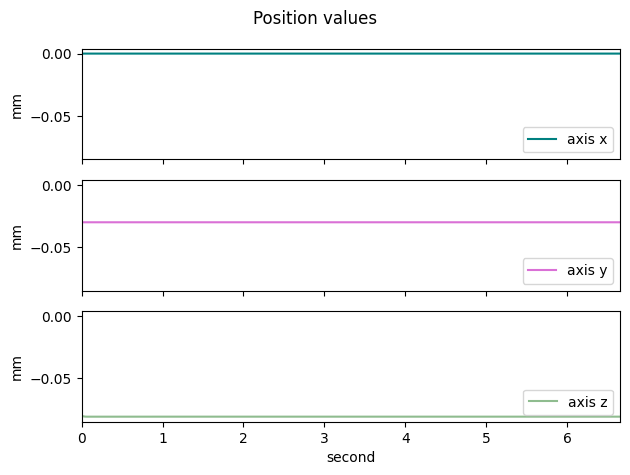

In [ ]:
Positions_x=[]
Positions_y=[]
Positions_z=[]

for i in range(len(Sensor_Mirror_Position)):
  Positions_x.append(Sensor_Mirror_Position[i][0])
  Positions_y.append(Sensor_Mirror_Position[i][1])
  Positions_z.append(Sensor_Mirror_Position[i][2])

#You can change or scale the values in array using:

# for i in range(len(Positions_x)):
#    Positions_x[i]=Positions_x[i]-Positions_x[0]
#    Positions_y[i]=Positions_y[i]-Positions_y[0]
#    Positions_z[i]=Positions_z[i]-Positions_z[0]


fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Position values')
axs[0].plot(np.asarray(times), np.asarray(Positions_x), label=["axis x"], color="teal")
axs[1].plot(np.asarray(times), np.asarray(Positions_y), label=["axis y"], color="orchid")
axs[2].plot(np.asarray(times), np.asarray(Positions_z), label=["axis z"], color="darkseagreen")

for ax in axs.flat:
    ax.set(xlabel='second', ylabel='mm')
for ax in axs.flat:
    ax.label_outer()

axs[0].set_xlim(0, times[-1])
axs[1].set_xlim(0, times[-1])
axs[2].set_xlim(0, times[-1])
# axs[0].set_ylim(-5,50)
# axs[1].set_ylim(-5,50)
# axs[2].set_ylim(-5,50)
axs[0].legend(frameon=True, loc='lower right')
axs[1].legend(frameon=True, loc='lower right')
axs[2].legend(frameon=True, loc='lower right')
plt.tight_layout()
plt.show()

Graphical rappresentation of energy

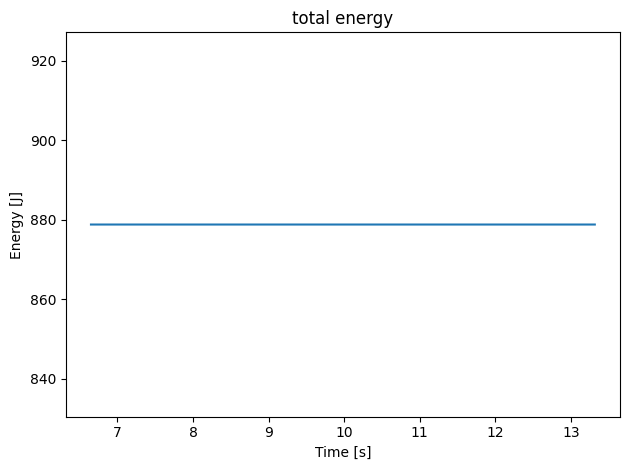

In [8]:
#Energy of the mirror 

SIM_DURATION = n_frames/fps  # seconds
n_steps = int(SIM_DURATION / model.opt.timestep)
sim_time = np.zeros(n_steps)
energy = np.zeros(n_steps)

for i in range(n_steps):
  mujoco.mj_step(model, data)
  sim_time[i] = data.time
  energy[i] = data.energy[0] + data.energy[1]

plt.plot(sim_time, energy)
plt.title('total energy')
plt.xlabel('Time [s]')
plt.ylabel('Energy [J]')
plt.tight_layout()

# TESTS

In [9]:
#OSSERVAZIONI
#scrivere una variabile che entra dentro l'xml e che modifica la posizione dell'hook della marionetta->
#NB: TENENDO CONTO DELLE DISTANZE DEI PUNTI DI AGGANCIO DELLA MARIONETTA E DELLA SPECCHIO (guarda aggancio soffitto + marionetta per capire )



# #coord (x, y, z)
# #puoi usare il viewr per il modello basta inserire il comando "python -m mujoco.viewer model.xml" oppure attivi e poi trascini l xml
# """
# Struttura per xml
# nome= virgolette

# <mujoco>
#     <asset>
#         crei/ ridefinisci cose nuove cosi chiami texture/oggetti/materiali una volta per tutte
#     </asset>

#     <worldbody>
#         crei  cose che vanno nel simulatore , puoi creare piu cose 
#         <light name="top" pos="0 0 2"/> (definisce luce in posizione z=2 0,0=x,y nominato top)
#         <geom name="pole" type="capsule" fromto="0 0 .04 0 -.3 .04" size=".04" rgba="0 0 1 1"/> (definisce una capsula di lungezza da a (x-> x+dx) e il colore)
#         <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> (definisce la telecamera e in che posizione NB puo essere modificata ma guarda tutorial)
#         (NB se vuoi creare un oggetto con giunte:)
#         <body name="box_and_sphere" pos="0 0 0">
#             <joint name="swing" type="hinge" damping="1" axis="0 0 1"/> (hinge dice che pendola e dici dove attaccato)
#             <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/> (oggetto attaccato)
#         </body>

#     </worldbody>
#     (crea un motore per il pendolo e permette di oscillare l'oggetto)
#     <actuator>
#         <motor name="my_motor" joint="swing" gear="1"/>
#     </actuator>

#     <tendon>
#         <spatial name="wire" limited="true" range="0 0.35" width="0.003">
#         <site site="anchor"/>
#         <site site="hook"/>
#         </spatial>
#     </tendon>
    
#     <sensor>
#         <accelerometer name="accelerometer" site="IMU"/>
#     </sensor>
# </mujoco>
# virgolette
# """

In [10]:
# MJCF = """

# <mujoco>

#   <compiler meshdir="asset" texturedir="asset"/>

#   <statistic meansize=".05"/>

#   <visual>
#     <rgba haze="0.15 0.25 0.35 1"/>
#     <quality shadowsize="4096"/>
#     <map stiffness="700" shadowscale="0.5" fogstart="1" fogend="15" zfar="40" haze="1"/>
#   </visual>

#   <asset>
#     <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>

#     <material name="matplane" reflectance="0.3" texture="texplane" texrepeat="10 10" texuniform="true"/>
#   </asset>

#   <worldbody>
#     <light diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 2.0" dir="0 0 -1" castshadow="false"/>
#     <light directional="true" diffuse=".8 .8 .8" specular="0.2 0.2 0.2" pos="0 0 4" dir="0 0 -1"/>

#     <geom name="ground" type="plane" size="0 0 1" pos="0 0 -0.5" quat="1 0 0 0" material="matplane" condim="1"/>
#   </worldbody>

# <!-- Finita parte visuale  -->  

# <!-- 
#   <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="512"/>
#   <geom name="floor" type="plane" pos="0 0 -0.5" size="5 5 .1" material="grid"/>
#   <texture name="grid" type="2d" builtin="checker" rgb1=".2 .2 .2" rgb2="1 1 1" width="300" height="300" mark="none"/>
#   <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>   
# -->

# <!-- Finita parte prove  -->  


#   <asset>
#     <material name="mirror" reflectance="1"/>
#     <material name="wire_mat" rgba="0.8 0.8 0.8 1"/>
#   </asset>

#   <option gravity="0 0 -9.81"viscosity="0.00002"/>

#   <worldbody>
#     <light name="light" pos="0 0 1"/>


#     <site name="anchor1" pos="-.2 0 .3" size=".01"/>           <!--Punto dove metti la corda -->
#     <site name="anchor2" pos=".2 0 .3" size=".01"/>
#     <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>
#     <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>



#     <body name="bat" pos=".3 0 -.1">
#       <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
#       <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
#        size=".04" rgba="0 0 1 1"/>
#     </body>
  

  
#     <body name="cilindro" pos="0 0 -.1">
#       <joint name="free" type="free"/>
#       <geom name="cilindro"  size=".2" fromto="0 .05 0 0 -.05 0"  rgba="0 1 0 1" type="cylinder"/>
#       <site name="hook1" pos="-.2 0 0" size=".01"/>
#       <site name="hook2" pos=".2 0 0" size=".01"/>
#       <site name="IMU"/>
#     </body>




#   </worldbody>

  
#   <tendon>
#     <spatial name="wire1" limited="true" range="0 0.35" width="0.005" damping="0.1">
#       <site site="anchor1"/>
#       <site site="hook1"/>
#     </spatial>
#   </tendon>
  
#   <tendon>
#     <spatial name="wire2" limited="true" range="0 0.35" width="0.005" damping="0.1">
#       <site site="anchor2"/>
#       <site site="hook2"/>
#     </spatial>
#   </tendon>

# <!--
#   <contact>
#     <exclude body1="wire1" body2="cilindro"/>
#     <exclude body1="wire2" body2="cilindro"/>
#   </contact>
# -->
#   <actuator>
#     <motor name="my_motor" joint="swing"/>
#   </actuator>

#   <sensor>
#     <accelerometer name="accelerometer" site="IMU"/>
#   </sensor>
# </mujoco>
# """


# model = mujoco.MjModel.from_xml_string(MJCF)
# data = mujoco.MjData(model)
# height = 480
# width = 480

# with mujoco.Renderer(model, height, width) as renderer:
#   mujoco.mj_forward(model, data)
#   renderer.update_scene(data, "fixed")

#   media.show_image(renderer.render())

In [11]:



# MJCF = """


# <mujoco>
  
# <!-- Parte visuale -->

#   <compiler  texturedir="asset"/>
#   <statistic meansize=".05"/>

#   <visual>
#     <rgba haze="0.15 0.25 0.35 1"/>
#     <quality shadowsize="4096"/>
#     <map stiffness="700" shadowscale="0.5" fogstart="1" fogend="15" zfar="40" haze="1"/>
#   </visual>

#   <asset>
#     <texture name="texplane" type="2d" builtin="checker" rgb1=".2 .3 .4" rgb2=".1 0.15 0.2" width="512" height="512" mark="cross" markrgb=".8 .8 .8"/>
#     <material name="matplane"  texture="texplane" texrepeat="10 10" texuniform="true"/>       <!--Se vuoi il riflesso del pavimento +reflectance="0.3"+ -->
#   </asset>

#   <worldbody>
#     <light diffuse=".4 .4 .4" specular="0.1 0.1 0.1" pos="0 0 2.0" dir="0 0 -1" castshadow="false"/>
#     <light directional="true" diffuse=".8 .8 .8" specular="0.2 0.2 0.2" pos="0 0 4" dir="0 0 -1"/>
#     <geom name="ground" type="plane" size="0 0 1" pos="0 0 -0.5" quat="1 0 0 0" material="matplane" condim="1"/>
#   </worldbody>

# <!-- Finita parte visuale  -->  


# <!-- Finita parte prove  -->  


#   <asset>
#     <material name="reflectance" reflectance="1"/>             <!-- caratteristiche -->
#     <material name="wire_mat" rgba="0.8 0.8 0.8 1"/>

    
#     <!-- CAMBIARE IL PATH DEI FILE STL -->

#     <mesh name="specchio" file="STL/Specchio2.stl" scale="0.002 0.002 0.002" />                        <!-- Specchio collegamento al file STL -->
  
    
#     <!-- Fibre collegamento al file STL -->
    
#     <!--
    
#     <mesh name="Fibra1" file="STL/assieme_dondola1-Fibra_1.15-1.STL" scale="0.002 0.002 0.002" />      <!-- Fibra 1 collegamento al file STL -->
#     <mesh name="Fibra2" file="STL/assieme_dondola1-Fibra_1.15-2.STL" scale="0.002 0.002 0.002" />      
    
#     -->

  
#   <!-- ========================================================================================================  -->

#   </asset>

#   <option gravity="0 0 -9.81" viscosity="0.00002"/>             <!-- Parametri fisici -->

#   <worldbody>
#     <light name="light" pos="0 0 1"/>                           <!-- Luce -->
#     <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/> <!-- Telecamera -->
#     <site name="anchor1" pos="-.2 0 .3" size=".01"/>            <!-- Punto dove metti la corda  -->
#     <site name="anchor2" pos=".2 0 .3" size=".01"/>             <!-- Punto dove metti la corda  -->


#   <!-- I due cavi che collegano lo specchio -->
       
# <!--
#     <body name="Fibra1" pos="-.212 -.242 -.07">       
#       <geom type="mesh" mesh="Fibra1"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />         
#     </body>
    
#     <body name="Fibra2" pos="-.212 -.242 -.07">       
#       <geom type="mesh" mesh="Fibra2"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />         
#     </body>
# -->
   

#   <!-- ========================================================================================================  -->

                                                                                                                      
#   <!-- Specchio che si muove e riflette -->                                                                                                                  
#     <body name="mirror" pos="0 0 -.1">
#       <joint name="free" type="free"/>
#       <geom type="mesh" mesh="specchio"  pos="0 0 -0.37" rgba="0.8 0.6 0.4 1" size=".2" euler="90 90 0" />          <!--Centro di massa si trova verso il 2 buco (-0.37), ma non stai considerando i pasetti e tutto-->
#       <site name="hook1" pos="-.2 0 0" size=".01"/>                                                                 <!-- L'attacco si trova a -0.3455 -->
#       <site name="hook2" pos=".2 0 0" size=".01"/>
#       <inertial pos="0 0 0" mass="0.1" diaginertia="0.1 0.1 0.1" />
#       <site name="ft_sensor" pos="0 -0.030 0" rgba="1 0 0 0.3" size="0.001 0.001 0.001" type="box"/>  
#       <site name="IMU"/>
#     </body>

    
#   <!-- ========================================================================================================  -->




#   </worldbody>


# <!-- PER VEDERE GLI ASSI CARTESIANI https://mujoco.readthedocs.io/en/latest/programming/samples.html#sasimulate -->


#   <worldbody>
#     <body name="x" pos="0.8 1 1">
#         <geom name="x" type="box" size="0.4 0.1 0.1" pos="0 0 0" rgba="1 0 0 1"/>
#     </body>
#     <body name="y" pos="1 0.8 1">
#       <geom name="y" type="box" size="0.1 0.4 0.1" pos="0 0 0" rgba="0 1 0 1"/>
#     </body>
#     <body name="z" pos="1 1 0.8">
#     <geom name="z" type="box" size="0.1 0.1 0.4" pos="0 0 0" rgba="0 0 1 1"/>
#     </body> 
#   </worldbody>

  
#   <!-- ========================================================================================================  -->

#   <tendon>
#     <spatial name="wire1" limited="true" range="0 0.35" width="0.005" damping="0.1">
#       <site site="anchor1"/>
#       <site site="hook1"/>
#     </spatial>
#   </tendon>
  
#   <tendon>
#     <spatial name="wire2" limited="true" range="0 0.35" width="0.005" damping="0.1">
#       <site site="anchor2"/>
#       <site site="hook2"/>
#     </spatial>
#   </tendon>

  


  
#   <sensor>
#     <accelerometer name="accelerometer" site="IMU"/>
#     <force name = "force" site="ft_sensor" />
#   </sensor>

# </mujoco>
# """


# model = mujoco.MjModel.from_xml_string(MJCF)
# data = mujoco.MjData(model)
# height = 480
# width = 480

# with mujoco.Renderer(model, height, width) as renderer:
#   mujoco.mj_forward(model, data)
#   renderer.update_scene(data, "fixed")

#   media.show_image(renderer.render())



